# Assessing the first baroclinic Rossby radius of deformation
__Kjersti Stangeland - Summer 2025 - The Norwegian Meteorological Insitute__

#### The project - Havvind

A scenario with Norwegian wind farms at sea has been developed in a collaboration with NVE. The period 2/2-2022 til 30/6-2022 is simulated with MEPS, WaveWatch III, og Norkyst v3. There are to versions of the simulations:
* A control run based of the current situation with no Norwegian wind farms at sea
* An experiment with simulated wind farms.

In the experiments, the only direct parametrization of the windmills are in MEPS. Therefore, effects on waves and ocean cirulation is indirectly seen through changed surface fluxes.

__Details on the wind farms:__
* Height of turbines is 165 m
* Radius 143 m
* 2.5 km distance between turbines
* 6 (?) different farms along the Norwegian coast

__Sørvest F__
* A wind farm south west of Norway
* 1x1500MW (430 km²) + 2x2100MW (600km² + 600 km²)
* 258 turbines

### Calculation of mean internal Rossby radius

To investigate the impact of wind farms at sea it is useful to make the study area smaller, i.e. not use the whole model domain. The Rossby radius or deformation radius allows us to delimit the area safely while making sure that the relevant baroclinic dynamics are still within the domain. By taking 1-2 deformation radii as our domain of investigation around the wind farm, we're making sure that the internal dynamics are dominated by internal baroclinic instabilities, and that changes seen are due to interference of wind mills and not other large scale effects. The radius is telling about the length of deformation of a wave, that is a length scale where the rotation of Earth affects the currents and geostrophy dominates.

Sperrevik et al. (2017) calculated the internal Rossby radii using the following method.

$$R_1 = \frac{c_1}{\mid f \mid}$$
where $f$ is the local Coriolis parameter and $c_1$ the phase speed of a first mode baroclinic gravity wave. The phase speed can be solved as an eigenvalue problem, but we will deploy the method of Chelton et al. (1998) and use the WKB-approximation.
$$R_1 \approx R_1^{WKB} = \frac{1}{\mid f \mid \pi}\int_{-H}^{0}N(z) dz$$

Here, $H$ is the local water depth and $N$ the buoyancy frequency. Sperrevik et al. (2017) calculated the radius for an area in Northern Norway, Lofoten, as shown in the figure below.

<p align="center">
  <img src="Sperrevik_etal_2017_fig5.png" alt="Sperrevik et al. (2017)">
</p>

Here we have the internal deformation radius for the spring months of 1984. The radii has its minimum after the winter and increases towards the summer due to a stronger stratification developing. I will use this figure as a reference to see if the values I compute are reasonable.

Broström (2008) investigated the upper ocean response to disturbances caused by large wind farms, with a focus on the effects due to the wind wake. He found using simple analytical models and idealized numerical experiments that as the wind wake trigger a horizontal gradient in wind stress, the Ekman response is changed due to the curl of the wind stress. More explicitly, upwelling/downwelling velocities exceeding 1 m/day if the characteristic with of the wind wake is of the same size or larger than the internal radius of deformation.

So the further analysis will focus on finding an estimate of the deformation radius of the region around Sørvest F to limit the study area for further analyis, while also comparing the findings to the characteristic length scale of the wind wake.

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import numpy as np
import xarray as xr
import cartopy 
from datetime import datetime, timedelta
import pandas as pd
from get_turbine_coords import get_turbine_coords
from netCDF4 import Dataset
from roppy import SGrid
import xroms
from cartopy import config
from glob import glob

%load_ext autoreload
%autoreload 2

In [2]:
# Opening a file to retrieve the grid
fid = Dataset('/lustre/storeB/project/nwp/havvind/hav/results/reference/REF-02/norkyst_avg_0001.nc')
grid = SGrid(fid)
del fid

In [3]:
sorvest_F = get_turbine_coords('/lustre/storeB/project/nwp/havvind/turbine_coordinates/windfarms_Sorvest_F.txt')

In [4]:
lon = grid.lon_rho
lat = grid.lat_rho

In [5]:
def find_indices_of_point(grid, target_lon, target_lat):
    lon = grid.lon_rho
    lat = grid.lat_rho

    y, x = xroms.argsel2d(lon, lat, target_lon, target_lat)

    return y, x

In [6]:
# Finding eta_rho and xi_rho incides of Sørvest midpoints
j_N, i_N = find_indices_of_point(grid, 4.673576935, 57.03354683)  # Turbine cluster North

j_S, i_S = find_indices_of_point(grid, 4.764045976, 56.70158331)  # Turbine cluster South

j_E, i_E = find_indices_of_point(grid, 5.215666154, 56.81933541)  # Turbine cluster East

In [7]:
""" proj = ccrs.NorthPolarStereo()

fig, ax = plt.subplots(1, 2, figsize=(10,6), subplot_kw={'projection': proj})
cmap='cmo.deep'

# Zoomed in plot
ax[0].set_extent([4, 6, 56, 57.5], crs=ccrs.PlateCarree())
area_plot = ax[0].pcolormesh(lon, lat, ds.gamma_r[0, :, :], transform=ccrs.PlateCarree(), cmap=cmap)
cbar = plt.colorbar(area_plot, ax=ax[0], orientation='vertical', shrink=0.8)
cbar.set_label('Rossby deformation radius (m)', labelpad=10)
cbar.ax.tick_params(labelsize=10)

ax[0].set_title('Sørvest F')

# Whole domain plot
domain_plot = ax[1].pcolormesh(lon, lat, ds.gamma_r[0, :, :], transform=ccrs.PlateCarree(), cmap=cmap)
cbar = plt.colorbar(domain_plot, ax=ax[1], orientation='vertical', shrink=0.8)
cbar.set_label('Rossby deformation radius (m)', labelpad=10)
cbar.ax.tick_params(labelsize=10)

ax[1].set_title('Norkyst v3 domain')


for axs in ax.flatten():
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=3) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

ax[0].plot(lon[j_N, i_N], lat[j_N, i_N], transform=ccrs.PlateCarree(), color='magenta', marker='o', markersize=5, label='SV-F North')
ax[0].plot(lon[j_S, i_S], lat[j_S, i_S], transform=ccrs.PlateCarree(), color='limegreen', marker='o', markersize=5, label='SV-F South')
ax[0].plot(lon[j_E, i_E], lat[j_E, i_E], transform=ccrs.PlateCarree(), color='darkorange', marker='o', markersize=5, label='SV-F East')


fig.suptitle(time) """

" proj = ccrs.NorthPolarStereo()\n\nfig, ax = plt.subplots(1, 2, figsize=(10,6), subplot_kw={'projection': proj})\ncmap='cmo.deep'\n\n# Zoomed in plot\nax[0].set_extent([4, 6, 56, 57.5], crs=ccrs.PlateCarree())\narea_plot = ax[0].pcolormesh(lon, lat, ds.gamma_r[0, :, :], transform=ccrs.PlateCarree(), cmap=cmap)\ncbar = plt.colorbar(area_plot, ax=ax[0], orientation='vertical', shrink=0.8)\ncbar.set_label('Rossby deformation radius (m)', labelpad=10)\ncbar.ax.tick_params(labelsize=10)\n\nax[0].set_title('Sørvest F')\n\n# Whole domain plot\ndomain_plot = ax[1].pcolormesh(lon, lat, ds.gamma_r[0, :, :], transform=ccrs.PlateCarree(), cmap=cmap)\ncbar = plt.colorbar(domain_plot, ax=ax[1], orientation='vertical', shrink=0.8)\ncbar.set_label('Rossby deformation radius (m)', labelpad=10)\ncbar.ax.tick_params(labelsize=10)\n\nax[1].set_title('Norkyst v3 domain')\n\n\nfor axs in ax.flatten():\n    for i in range(len(sorvest_F.coordinates)):\n        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.

__Onsdag__
- Prøv å åpne flere filer og plot time series
- Se om du klarer å finne månedlig mean -> eks funksjon som leser inn alle filer med 'ref-02' og så tar gj.snitt og spytter ut

Vil ha:
- kart over månedlig mean
- tidsserie i punkt av månedlig mean evt rolling mean?? idk hva gir fysisk mening
- prøve å ta horisontalt gj snitt av området og plotte tidsserie

Når det er gjort: ta median elns av verdiene og bruk det til å avgrense rundt. dvs hent ut indekser som trengs!

Videre:
start med å regne ut på dagsfil med/uten turbin. når metoden sitter -> lag program som kjører alle filene eller på time mean av filene.

In [8]:
# Extracting paths to files containing the computed Rossby deformation radius

filefolder = glob('/home/kjsta7412/sommer_25/MET_sommer25/output_bdr/REF')

months = {
"02": 27,  # February
"03": 31,  # March
"04": 30,  # April
"05": 31,  # May
"06": 30   # June
}

files=[]

for month, days in months.items():
    for day in range(1, days + 1): 
        day_str = f"{day:04}"
        file_path = f'/REF_{month}_norkyst_avg_{day_str}_brr.nc'
        files.append(filefolder[0]+file_path)

In [9]:
def R1_rolling_mean_all(files):
    # Opening all files
    full_ds = xr.open_mfdataset(files)

    # Converting ocean_time from seconds since initialization to datetime values
    ocean_time = full_ds.ocean_time.values
    datetime_array = [datetime.fromtimestamp(ot) for ot in ocean_time]
    full_ds['ocean_time'] = datetime_array

    # Computing the rolling mean of rossby radius
    R1_roll = full_ds.gamma_r.rolling(ocean_time=7).mean()

    return R1_roll

In [10]:
R1_roll_7 = R1_rolling_mean_all(files)

Text(0.5, 1.0, 'Rossby deformation radius \n Rolling mean, window = 7 days')

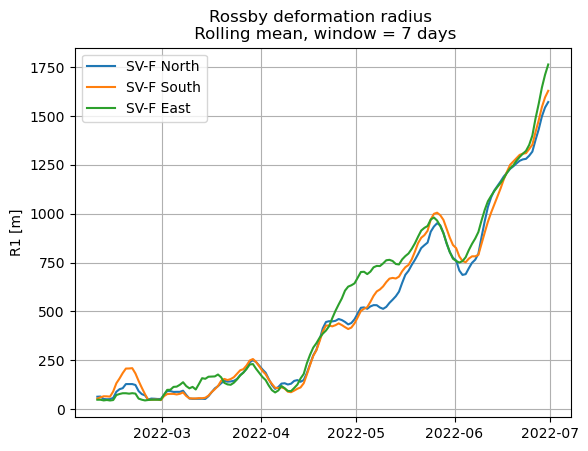

In [11]:
fig, ax = plt.subplots()

ax.plot(R1_roll_7.ocean_time, R1_roll_7.isel(eta_rho=j_N, xi_rho=i_N), label='SV-F North')
ax.plot(R1_roll_7.ocean_time, R1_roll_7.isel(eta_rho=j_S, xi_rho=i_S), label='SV-F South')
ax.plot(R1_roll_7.ocean_time, R1_roll_7.isel(eta_rho=j_E, xi_rho=i_E), label='SV-F East')

ax.legend()
ax.grid()

ax.set_ylabel('R1 [m]')

plt.title('Rossby deformation radius \n Rolling mean, window = 7 days')

In [12]:
def R1_rolling_mean_all(files):
    # Opening all files
    full_ds = xr.open_mfdataset(files)

    # Converting ocean_time from seconds since initialization to datetime values
    ocean_time = full_ds.ocean_time.values
    datetime_array = [datetime.fromtimestamp(ot) for ot in ocean_time]
    full_ds['ocean_time'] = datetime_array

    # Computing the rolling mean of rossby radius
    R1_roll = full_ds.gamma_r.rolling(ocean_time=25).mean()

    return R1_roll

In [13]:
R1_roll_25 = R1_rolling_mean_all(files)

Text(0.5, 1.0, 'Rossby deformation radius \n Rolling mean, window = 25 days')

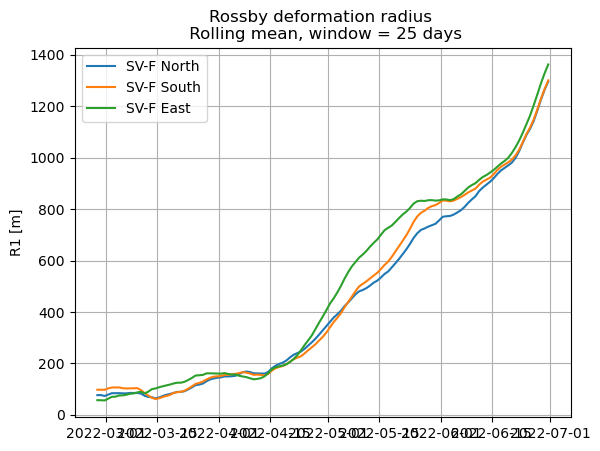

In [14]:
fig, ax = plt.subplots()

ax.plot(R1_roll_25.ocean_time, R1_roll_25.isel(eta_rho=j_N, xi_rho=i_N), label='SV-F North')
ax.plot(R1_roll_25.ocean_time, R1_roll_25.isel(eta_rho=j_S, xi_rho=i_S), label='SV-F South')
ax.plot(R1_roll_25.ocean_time, R1_roll_25.isel(eta_rho=j_E, xi_rho=i_E), label='SV-F East')

ax.legend()
ax.grid()

ax.set_ylabel('R1 [m]')

plt.title('Rossby deformation radius \n Rolling mean, window = 25 days')

In [15]:
def extract_R1_all(files):
    # Opening all files
    full_ds = xr.open_mfdataset(files)

    # Converting ocean_time from seconds since initialization to datetime values
    ocean_time = full_ds.ocean_time.values
    datetime_array = [datetime.fromtimestamp(ot) for ot in ocean_time]
    full_ds['ocean_time'] = datetime_array

    # Computing the rolling mean of rossby radius
    R1 = full_ds.gamma_r

    return R1

In [16]:
R1 = extract_R1_all(files)

Text(0.5, 1.0, 'Rossby deformation radius')

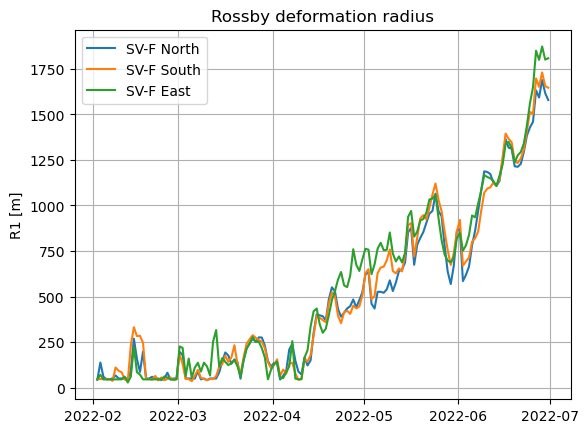

In [17]:
fig, ax = plt.subplots()

ax.plot(R1.ocean_time, R1.isel(eta_rho=j_N, xi_rho=i_N), label='SV-F North')
ax.plot(R1.ocean_time, R1.isel(eta_rho=j_S, xi_rho=i_S), label='SV-F South')
ax.plot(R1.ocean_time, R1.isel(eta_rho=j_E, xi_rho=i_E), label='SV-F East')

ax.legend()
ax.grid()

ax.set_ylabel('R1 [m]')

plt.title('Rossby deformation radius')

In [18]:
def monthly_mean_SV_map(files):
    # Opening all files
    full_ds = xr.open_mfdataset(files)

    # Converting ocean_time from seconds since initialization to datetime values
    ocean_time = full_ds.ocean_time.values
    datetime_array = [datetime.fromtimestamp(ot) for ot in ocean_time]
    full_ds['ocean_time'] = datetime_array

    ds_monthly = full_ds.resample(ocean_time='1M').mean(dim='ocean_time')

    
    return ds_monthly
    

In [19]:
ds_monthly = monthly_mean_SV_map(files)

Text(0.5, 0.75, 'Rossby radius of deformation - monthly mean')

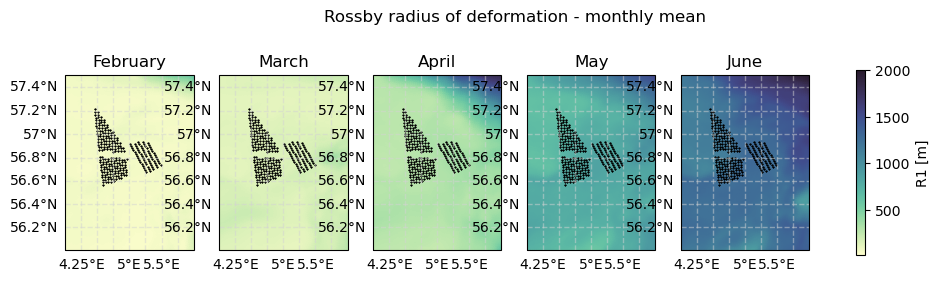

In [20]:
proj = ccrs.Mercator()
fig, ax = plt.subplots(1, 5, figsize=(12, 6), subplot_kw={'projection':proj})

cmap='cmo.deep'

vmin = 20
vmax = 2000

for axs in ax:
    axs.set_extent([4, 6, 56, 57.5], crs=ccrs.PlateCarree())
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

for i in range(5):
    plot = ax[i].pcolormesh(lon, lat, ds_monthly.gamma_r[i, :, :], 
                            transform=ccrs.PlateCarree(), cmap=cmap,
                            vmin=vmin, vmax=vmax)
    
ax[0].set_title('February')
ax[1].set_title('March')
ax[2].set_title('April')
ax[3].set_title('May')
ax[4].set_title('June')
    
cbar = fig.colorbar(plot, ax=ax, orientation='vertical', shrink=0.4)
cbar.set_label('R1 [m]')

fig.suptitle('Rossby radius of deformation - monthly mean', y=0.75)


Text(0.5, 0.75, 'Rossby radius of deformation - monthly mean')

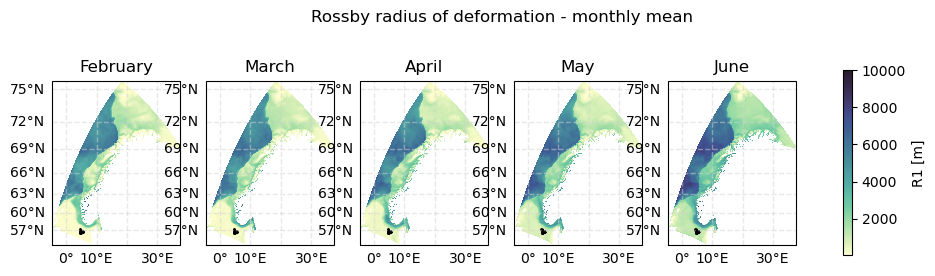

In [21]:
proj = ccrs.Mercator()
fig, ax = plt.subplots(1, 5, figsize=(12, 6), subplot_kw={'projection':proj})

cmap='cmo.deep'

vmin = 20
vmax = 10000

for axs in ax:
    #axs.set_extent([4, 6, 56, 57.5], crs=ccrs.PlateCarree())
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

for i in range(5):
    plot = ax[i].pcolormesh(lon, lat, ds_monthly.gamma_r[i, :, :], 
                            transform=ccrs.PlateCarree(), cmap=cmap,
                            vmin=vmin, vmax=vmax)
    
ax[0].set_title('February')
ax[1].set_title('March')
ax[2].set_title('April')
ax[3].set_title('May')
ax[4].set_title('June')
    
cbar = fig.colorbar(plot, ax=ax, orientation='vertical', shrink=0.4)
cbar.set_label('R1 [m]')

fig.suptitle('Rossby radius of deformation - monthly mean', y=0.75)


In [22]:
# Guessing on a midpoint of the wind farm
mid_lat = 56.8
mid_lon = 5.0

j_mid, i_mid = find_indices_of_point(grid, mid_lon, mid_lat)

In [23]:
def monthly_mean_area(files):
    full_ds = xr.open_mfdataset(files)

    # Converting ocean_time from seconds since initialization to datetime values
    ocean_time = full_ds.ocean_time.values
    datetime_array = [datetime.fromtimestamp(ot) for ot in ocean_time]
    full_ds['ocean_time'] = datetime_array

    # Choosing an area around the wind park
    area_lon = [4, 6]
    area_lat = [56, 57.5]

    j1, i1 = find_indices_of_point(grid, area_lon[0], area_lat[0])
    j2, i2 = find_indices_of_point(grid, area_lon[1], area_lat[0])
    j3, i3 = find_indices_of_point(grid, area_lon[1], area_lat[1])
    j4, i4 = find_indices_of_point(grid, area_lon[0], area_lat[1])

    j_min = np.min([j1, j2, j3, j4])
    j_max = np.max([j1, j2, j3, j4])

    i_min = np.min([i1, i2, i3, i4])
    i_max = np.max([i1, i2, i3, i4])
    
    ds_area = full_ds.isel(eta_rho=slice(j_min, j_max), xi_rho=slice(i_min, i_max))
    R1_area_mean = ds_area.mean(dim=['eta_rho', 'xi_rho'])

    return R1_area_mean.gamma_r

In [24]:
R1_area_mean = monthly_mean_area(files)

In [25]:
overall_meantime = ds_monthly.gamma_r.mean(dim='ocean_time')

Text(0.5, 0.98, 'Time mean of Rossby deformation radius')

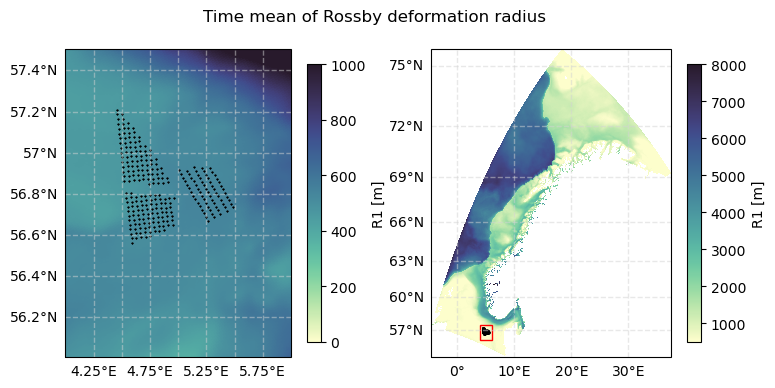

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4), subplot_kw={'projection':proj})
#plt.subplots_adjust(wspace=0.2)

cmap = 'cmo.deep'

ax[0].set_extent([4, 6, 56, 57.5])
pll = ax[0].pcolormesh(lon, lat, overall_meantime, transform=ccrs.PlateCarree(), cmap=cmap, vmin=0, vmax=1000)
cbar = fig.colorbar(pll, ax=ax[0], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

pl = ax[1].pcolormesh(lon, lat, overall_meantime, transform=ccrs.PlateCarree(), cmap=cmap, vmin=500, vmax=8000)
cbar = fig.colorbar(pl, ax=ax[1], orientation='vertical', shrink=0.9)
cbar.set_label('R1 [m]')

area_lon = [4, 6, 6, 4]
area_lat = [56, 56, 57.5, 57.5]

ax[1].fill(area_lon, area_lat, transform=ccrs.PlateCarree(), color='none', edgecolor='red', linewidth=1)

for axs in ax:
    for i in range(len(sorvest_F.coordinates)):
        axs.plot(sorvest_F.coordinates[i][0], sorvest_F.coordinates[i][1], transform = ccrs.PlateCarree(), color = 'black', marker ='*', markersize=1) 
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable top labels
    gl.right_labels = False  # Disable right labels
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

fig.suptitle('Time mean of Rossby deformation radius')

In [49]:
R1_area_mon = R1_area_mean.resample(ocean_time='1M').mean(dim='ocean_time')

Text(0.5, 1.0, 'Rossby deformation radius \n Horizontal mean of Sørvest-F region')

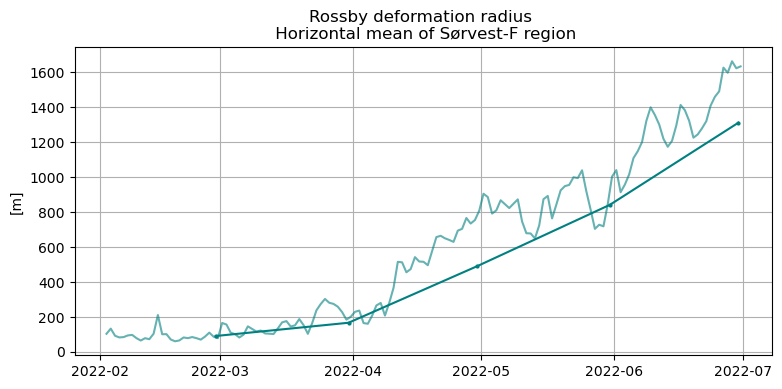

In [60]:
plt.figure(figsize=(9, 4))
plt.plot(R1_area_mean.ocean_time, R1_area_mean, 'teal', alpha=0.6)
plt.plot(R1_area_mon.ocean_time, R1_area_mon, 'teal', marker='o', markersize=2)
plt.grid()
plt.ylabel('[m]')
plt.title('Rossby deformation radius \n Horizontal mean of Sørvest-F region')

__Torsdag__

- Gjør et forsøk på å avgrense området med bruk av de månedlige gjennomsnittene for området.
- Se om du får det til og videre prøv på mixed layer depth på dette området.
- Dvs. lag en funksjon som leser en fl, lager et subset på området, regner ut mixed layer depth og skriver til fil. Loop gjennom hver dagsfil.
- Plot mixed layer depth